# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [149]:
def clean_portfolio(df=portfolio):
    '''
    Description: cleaning protfolio datafram to OneHotEncoding(dummy variables)
    Input: portfolio
    Output: the cleaned portfolio
    '''
    # duration days -> hours, consistent with transcript
    portfolio_new = portfolio.copy()
    portfolio_new['duration'] = portfolio['duration']*24
    # rename id -> offer_id
    portfolio_new.rename(columns={'id':'offer_id'}, inplace = True)
    
    # get dummies to channel and offer_type
    channels = portfolio['channels'].apply(lambda x: ','.join(x))
    channels = pd.Series(channels).str.get_dummies(',')
    
    offer_type = pd.get_dummies(portfolio['offer_type'])
    
    # new cleaned portfolio
    portfolio_new = pd.concat([channels, portfolio_new[['difficulty', 'duration', 'offer_id', 'reward']], offer_type], axis=1, sort=False)
    
    return portfolio_new  

In [155]:
len(portfolio)

10

In [154]:
print(len(portfolio))
portfolio_new = portfolio.copy()
portfolio_new['duration'] = portfolio['duration']*24
# rename id -> offer_id
print(len(portfolio_new))
portfolio_new.rename(columns={'id':'offer_id'}, inplace = True)

# get dummies to channel and offer_type
channels = portfolio['channels'].apply(lambda x: ','.join(x))
channels = pd.Series(channels).str.get_dummies(',')

offer_type = pd.get_dummies(portfolio['offer_type'])

# new cleaned portfolio
portfolio_new = pd.concat([channels, portfolio_new[['difficulty', 'duration', 'offer_id', 'reward']], offer_type], axis=1, sort=False)


10
10


In [150]:
portfolio_new = clean_portfolio()
portfolio_new.head()

,email,mobile,social,web,difficulty,duration,offer_id,reward,bogo,discount,informational
0,1,1,1,0,10,168,ae264e3637204a6fb9bb56bc8210ddfd,10,1,0,0
1,1,1,1,1,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,0,0
2,1,1,0,1,0,96,3f207df678b143eea3cee63160fa8bed,0,0,0,1
3,1,1,0,1,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,0,0
4,1,0,0,1,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,0,1,0


In [151]:
portfolio_new.shape

(10, 11)

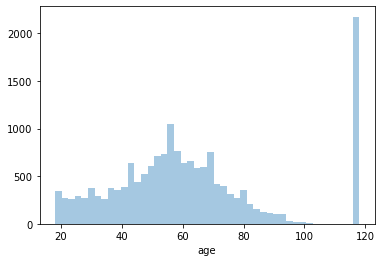

In [6]:
sns.distplot(profile['age'], kde=False)

In [7]:
pd.DataFrame(profile.groupby(by='age', as_index=False)['id'].count()).sort_values(by = 'age', ascending=False).head()

,age,id
84,118,2175
83,101,5
82,100,12
81,99,5
80,98,5


In [8]:
print(profile.isnull().sum())
print('/')
print(sum(profile['age'] ==118))

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64
/
2175


In [9]:
print(profile['became_member_on'].min(), profile['became_member_on'].max())

20130729 20180726


In [10]:
def clean_profile(df=profile):
    #from sklearn.impute import SimpleImputer
    '''
    Description: cleaning profile dataframe
    Input: profile 
    Output: cleaned profile
    Features: [gender,age,id,became_member_on,income]
    '''

    # # age 118 makes no sense, replace 118 with unknown number
    # profile['age'].replace(118, np.nan,inplace=True)

    # drop 2175 nan
    profile_new = profile.dropna()

    # # gender: assign unknown to other
    # profile['gender'].replace('None', 'O', inplace=True)
    # get dummies to gender
    gender = pd.get_dummies(profile_new['gender'])

    # # impute with mean
    # imp_age, imp_income = SimpleImputer(missing_values=np.nan, strategy='mean'), \
    #     SimpleImputer(missing_values=np.nan, strategy='mean')
    # imp_age.fit(profile[['age']])
    # age = pd.DataFrame(imp_age.transform(profile[['age']]))

    # imp_income.fit(profile[['income']])
    # income = pd.DataFrame(imp_income.transform(profile[['income']]), columns={'income'})

    # get dummies to age
    #age_bins = pd.cut(age.to_numpy()[:,0], bins=range(10,110,10), labels=['10s','20s', '30s', '40s', '50s','60s', '70s', '80s', '90s'])
    age_bins = pd.cut(profile_new['age'], bins=range(10,110,10), labels=['10s','20s', '30s', '40s', '50s','60s', '70s', '80s', '90s'])
    age_cat = pd.get_dummies(age_bins)

    # datetime to become_member_on
    member_date = pd.to_datetime(profile_new['became_member_on'],format='%Y%m%d')
    member_year = pd.get_dummies(member_date.dt.year,prefix='year', prefix_sep='_')
    member_month = pd.get_dummies(member_date.dt.month,prefix='month', prefix_sep='_')


    profile_new = pd.concat([gender,age_cat,profile_new['id'],member_year,member_month,profile_new['income']], axis=1)
    

    return profile_new

In [11]:
profile_new =clean_profile()
profile_new.head()

,F,M,O,10s,20s,30s,40s,50s,60s,70s,...,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,income
1,1,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,112000.0
3,1,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,100000.0
5,0,1,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,70000.0
8,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,53000.0
12,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,51000.0


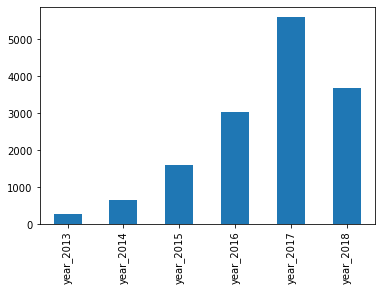

In [12]:
profile_new.loc[:,'year_2013':'year_2018'].sum().plot.bar()

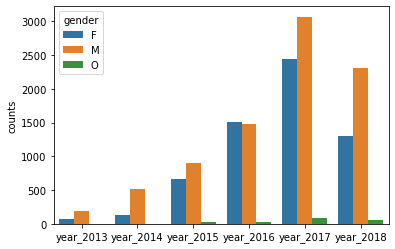

In [13]:
gender_year = pd.concat([profile['gender'].dropna(), profile_new.loc[:,'year_2013':'year_2018']],axis=1)
x = pd.DataFrame(gender_year.groupby('gender').sum().unstack(), columns={'counts'})
sns.barplot(x = x.index.get_level_values(0), y = x['counts'],hue = x.index.get_level_values(1),data = x)

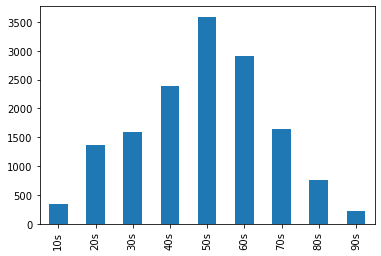

In [14]:
profile_new.loc[:,'10s':'90s'].sum().plot.bar()

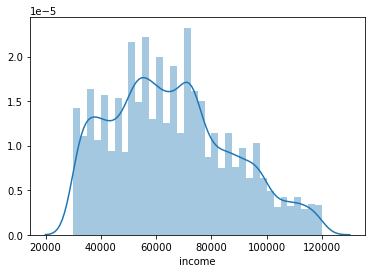

In [15]:
sns.distplot(profile_new['income'])

In [120]:
def clean_transcript(transcript, portfolio):
    """
    Description: cleaning transcript dataframe
    Input: transcript 
    Output: cleaned transcript
    Features: [gender,age,id,became_member_on,income]
    """
    # rename person_id to id
    transcript_new = transcript.rename(columns={'person':'id'})
    # remove the person who age 118 (those data points were removed)
    age_118_label = profile[profile['age'] == 118]['id']
    transcript_new = transcript_new[~transcript_new['id'].isin(age_118_label)]
    
    df_offer = transcript_new[transcript_new['event'].isin(['offer received', 'offer viewed', 'offer completed'])].reset_index()

    o_ids = []
    o_types = []
    for i in range(len(df_offer)):
        if df_offer.iloc[i]['event'] == 'offer completed':
            o_id = df_offer.iloc[i]['value']['offer_id']
        else:
            o_id = df_offer.iloc[i]['value']['offer id']
        o_ids.append(o_id)
        o_types.append(portfolio[portfolio['id'] == o_id]['offer_type'].values[0])
    
    df_offer['offer_id'] = pd.Series(o_ids)
    df_offer['offer_type'] = pd.Series(o_types)

    event_cat = pd.get_dummies(df_offer['event'])
    df_offer = pd.concat([df_offer, event_cat], axis=1)
    

    df_transaction = transcript_new[transcript_new['event'] == 'transaction'].reset_index()
    df_transaction['amount'] = df_transaction['value'].apply(lambda x:x['amount'])

    df_offer = df_offer.drop(['value', 'event'], axis = 1)
    df_transaction = df_transaction.drop(['value', 'event'], axis =1)
    return transcript_new, df_offer, df_transaction


In [119]:
# rename person_id to id
transcript_new = transcript.rename(columns={'person':'id'})
# remove the person who age 118 (those data points were removed)
age_118_label = profile[profile['age'] == 118]['id']
transcript_new = transcript_new[~transcript_new['id'].isin(age_118_label)]

df_offer = transcript_new[transcript_new['event'].isin(['offer received', 'offer viewed', 'offer completed'])].reset_index()

o_ids = []
o_types = []

# for i in range(len(df_offer)):
#     if df_offer.iloc[i]['event'] == 'offer completed':
#         o_id = df_offer.iloc[i]['value']['offer_id']
#     else:
#         o_id = df_offer.iloc[i]['value']['offer id']

#     o_ids.append(o_id)
#     o_types.append(portfolio[portfolio['id'] == o_id]['offer_type'].values[0])

# df_offer['offer_id'] = pd.Series(o_ids)
# df_offer['offer_type'] = pd.Series(o_types)

# event_cat = pd.get_dummies(df_offer['event'])
# df_offer = pd.concat([df_offer, event_cat], axis=1)

# df_transaction = transcript_new[transcript_new['event'] == 'transaction'].reset_index()
# df_transaction['amount'] = df_transaction['value'].apply(lambda x:x['amount'])

# df_offer = df_offer.drop(['value', 'event'], axis = 1)
# df_transaction = df_transaction.drop(['value', 'event'], axis =1)



In [ ]:
x = df_offer[df_offer['id'] == '0009655768c64bdeb2e877511632db8f']

for i in range(len(x)):
    if x.iloc[i]['event'] == 'offer completed':
        o_id = x.iloc[i]['value']['offer_id']
    else:
        o_id = df_offer.iloc[i]['value']['offer id']
    o_ids.append(o_id)
    o_types.append(portfolio[portfolio['id'] == o_id]['offer_type'].values[0])

In [121]:
transcript_new, df_offer, df_transaction = clean_transcript(transcript, portfolio)

In [ ]:
# df_offer_tst = df_offer.copy()
# df_transaction_tst = df_transaction.copy()


# df_transaction_tst.sort_values(by= ['id', 'time'], inplace = True)
# df_transaction_tst['cum'] = df_transaction_tst['amount'].cumsum()

# total_spend = pd.DataFrame(df_transaction_tst.groupby(by='id')['cum'].max()).rename(columns={'cum':'total'}).reset_index()
# df_transaction_tst = pd.merge(df_transaction_tst,total_spend, how ='left')


# df_offer_tst.sort_values(by= ['id', 'time'], inplace = True)


# df_merge = pd.merge(df_offer_tst, df_transaction_tst, how ='outer').sort_values(by=['id','time'])
# df_merge['cum'].fillna(method='ffill', inplace = True)
# df_merge['total'].fillna(method='ffill', inplace = True)
# df_merge.head(20)

In [144]:
def combine_offer_transaction(df_offer, df_transaction):
    
    df_transaction.sort_values(by=['id', 'time'], inplace=True)
    df_transaction['cum'] = df_transaction['amount'].cumsum()
    total_spend = pd.DataFrame(df_transaction_tst.groupby(by='id')['cum'].max()).rename(columns={'cum':'total'}).reset_index()
    df_transaction = pd.merge(df_transaction, total_spend, how='left')
    
    df_offer.sort_values(by=['id', 'time'], inplace =True)
    
    df_merge = pd.merge(df_offer, df_transaction, how='outer').sort_values(by=['id','time'])
    df_merge['cum'].fillna(method='ffill', inplace = True)
    df_merge['total'].fillna(method='ffill', inplace = True)
    
    df_merge.dropna(subset=['offer_id'], inplace=True)
    df_merge.drop('index', axis =1, inplace=True)
    return df_merge

# df_merge.head()
# #df_merge.dropna(subset=['offer_id'], inplace=True)
# df_merge.head()

In [145]:
df_merge = combine_offer_transaction(df_offer, df_transaction)

In [146]:
df_merge.head()

,id,time,offer_id,offer_type,offer completed,offer received,offer viewed,amount,cum,total
0,0009655768c64bdeb2e877511632db8f,168,5a8bc65990b245e5a138643cd4eb9837,informational,0.0,1.0,0.0,NaN,NaN,NaN
1,0009655768c64bdeb2e877511632db8f,192,5a8bc65990b245e5a138643cd4eb9837,informational,0.0,0.0,1.0,NaN,NaN,NaN
2,0009655768c64bdeb2e877511632db8f,336,3f207df678b143eea3cee63160fa8bed,informational,0.0,1.0,0.0,NaN,22.16,127.6
3,0009655768c64bdeb2e877511632db8f,372,3f207df678b143eea3cee63160fa8bed,informational,0.0,0.0,1.0,NaN,22.16,127.6
4,0009655768c64bdeb2e877511632db8f,408,f19421c1d4aa40978ebb69ca19b0e20d,bogo,0.0,1.0,0.0,NaN,22.16,127.6


In [148]:
len(portfolio_new)

10

In [147]:
df_merge.shape, profile_new.shape, portfolio_new.shape

((148805, 10), (14825, 32), (10, 11))

In [ ]:
def combine_master(df_merge, profile_new, portfolio_new):
    df_master = pd.merge(df_merge, )
    


In [141]:
portfolio_new.head()

,email,mobile,social,web,difficulty,duration,offer_id,reward,bogo,discount,informational
0,1,1,1,0,10,168,ae264e3637204a6fb9bb56bc8210ddfd,10,1,0,0
1,1,1,1,1,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,0,0
2,1,1,0,1,0,96,3f207df678b143eea3cee63160fa8bed,0,0,0,1
3,1,1,0,1,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,0,0
4,1,0,0,1,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,0,1,0


In [65]:
x = pd.DataFrame(df_transaction_tst.groupby(by='id')['cum'].max()).rename(columns={'cum':'total'}).reset_index()
y = pd.merge(df_transaction_tst,x, how ='left')
y = y[]

,id,time,amount,cum,total
0,0009655768c64bdeb2e877511632db8f,228,22.16,22.16,127.6
1,0009655768c64bdeb2e877511632db8f,414,8.57,30.73,127.6
2,0009655768c64bdeb2e877511632db8f,528,14.11,44.84,127.6
3,0009655768c64bdeb2e877511632db8f,552,13.56,58.40,127.6
4,0009655768c64bdeb2e877511632db8f,576,10.27,68.67,127.6
...,...,...,...,...,...
123952,ffff82501cea40309d5fdd7edcca4a07,498,13.17,1734891.35,1734942.4
123953,ffff82501cea40309d5fdd7edcca4a07,504,7.79,1734899.14,1734942.4
123954,ffff82501cea40309d5fdd7edcca4a07,576,14.23,1734913.37,1734942.4
123955,ffff82501cea40309d5fdd7edcca4a07,606,10.12,1734923.49,1734942.4


In [82]:
df_transaction_tst.head()

,id,time,amount
12654,02c083884c7d45b39cc68e1314fec56c,0,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56
12659,54890f68699049c2a04d415abc25e717,0,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,0,18.97


In [111]:
user_id = profile_new['id'].unique()

In [ ]:
def df_master(portfolio_new, profile_new, df_offer, df_transcation):
    user_id = profile_new.unique()
    for u_id in user_id:
        # offer info
        rcd = df_offer[df_offer['id'] == u_id].sort_values(by = 'time')
        # transaction info
        transaction = df_transcation[df_transcation['id']==u_id].sort_values(by = 'time')
        # compare time to fill offer and trascation


        rcd = df_offer[transcript['person'] == p_id].sort_values(by = 'time')


    offer_id = []
    complete_offer = []
    viewed_offer = []
    for i in range(len(rcd)):
        if rcd.iloc[i]['event'] == 'offer completed':
            if rcd.iloc[i]['value']['offer_id'] in offer_id:
                complete_offer.append(offer_id)
        elif rcd.iloc[i]['event'] == 'offer received':
            offer_id.append(rcd.iloc[i]['value']['offer id'])
        elif rcd.iloc[i]['event'] == 'offer viewed':
            viewed_offer.append(rcd.iloc[i]['value']['offer id'])

    

In [122]:
# rename person_id to id
transcript_new = transcript.rename(columns={'person':'id'})
# remove the person who age 118 (those data points were removed)
age_118_label = profile[profile['age'] == 118]['id']
transcript_new = transcript_new[~transcript_new['id'].isin(age_118_label)]
transcript_new.shape, transcript.shape

((272762, 4), (306534, 4))

In [ ]:
offer_id = []
offer_type = []
amount = []
for i in range(len(transcript)):
    if transcript.iloc[i]['event'] == 'transaction':
        offer_id.append(np.nan)
        offer_type.append(np.nan)   
        amount.append(transcript.iloc[i]['value']['amount'])
    elif transcript.iloc[i]['event'] == 'offer completed':
        o_id = transcript.iloc[i]['value']['offer_id']
        offer_id.append(o_id)
        o_type = portfolio[portfolio['id'] == o_id]['offer_type'].values[0]
        offer_type.append(o_type)
    else:
        o_id = transcript.iloc[i]['value']['offer id']
        offer_id.append(o_id)
        o_type = portfolio[portfolio['id'] == o_id]['offer_type'].values[0]
        offer_type.append(o_type)      

In [ ]:
person_transcation = pd.DataFrame({'person': transcript[transcript['event'] == 'transaction']['person'], 'transcation':amount})

In [ ]:
transcript['offer_id'] = offer_id
transcript['offer_type'] = offer_type
complete_offer = transcript[transcript['event'] == 'offer completed']
complete_offer_join = pd.merge(complete_offer,transcript,on=['person','offer_id'],how='left')
complete_offer_join2 = complete_offer_join[complete_offer_join['event_y'] == 'offer viewed'].query('time_x > time_y')
person_complete_offer = complete_offer_join2[['person','offer_id','offer_type_x']]

In [ ]:
person_complete = person_complete_offer.groupby(by = ['person','offer_type_x'])['offer_id'].count().unstack()
person_complete = person_complete.fillna(0)
person_complete['informational'] = float(0)
person_complete['all'] = person_complete['bogo'] + person_complete['discount'] 
person_complete.head()

In [ ]:
person_receive = transcript[transcript['event'] =='offer received'].groupby(by = ['person','offer_type'])['offer_id'].count().unstack()
person_receive = person_receive.fillna(0)
person_receive['all'] = person_receive['bogo'] + person_receive['discount'] + person_receive['informational']
person_receive.head()

In [ ]:
person_view = transcript[transcript['event'] =='offer viewed'].groupby(by = ['person','offer_type'])['offer_id'].count().unstack()
person_view = person_view.fillna(0)
person_view['all'] = person_view['bogo'] + person_view['discount'] + person_view['informational']

In [ ]:
person_offer = pd.concat([person_receive, person_view, person_complete], axis =1, sort =False, join='outer')
person_offer= person_offer.fillna(0)
person_offer_multiidx = person_offer.copy()
columns1 = ['bogo_receive','discount_receive', 'informational_receive', 'all_receive',
           'bogo_view','discount_view', 'informational_view', 'all_view',
           'bogo_complete','discount_complete', 'informational_complete', 'all_complete']
columns2 = pd.MultiIndex.from_product([['Receive', 'View', 'Complete'], ['bogo', 'discount', 'informational', 'all']])
person_offer.columns = columns1
person_offer_multiidx.columns = columns2
person_offer.index.name = 'person'
person_offer_multiidx.index.name = 'person'
person_offer_multiidx.head()

In [ ]:
person_noview = person_offer_multiidx[(person_offer_multiidx.View['all'] == 0) & (person_offer_multiidx.Receive['all'] >0)]
person_transcation[person_transcation['person'].isin(person_noview.index)].groupby(by ='person').sum().plot.hist()
person_transcation.groupby(by ='person').sum().plot.hist()

In [ ]:
person_noview = person_offer_multiidx[(person_offer_multiidx.View['all'] == 0) & (person_offer_multiidx.Receive['all'] >0)]

In [ ]:
profile.head()

In [ ]:
sns.distplot(profile[profile['id'].isin(transcript['person'].unique())]['age'],kde=False)
sns.distplot(profile[profile['id'].isin(person_noview.index)].age, kde=False)

In [ ]:
profile[profile['id'].isin(person_noview.index)].groupby(by = 'gender').count()

In [ ]:
profile[profile['id'].isin(transcript['person'])]['income'].plot.hist()
profile[profile['id'].isin(person_noview.index)]['income'].plot.hist()

In [ ]:
person_offer_transcation = pd.merge(person_offer,person_transcation,on=['person'],how='left')
person_offer_transcation.head()

In [ ]:
df = pd.DataFrame()
person_ids = transcript['person'].unique()
n_offer = []
n_complete = []
n_view = []
for p_id in person_ids:
    rcd = transcript[transcript['person'] == p_id].sort_values(by = 'time')
    offer_id = []
    complete_offer = []
    viewed_offer = []
    for i in range(len(rcd)):
        if rcd.iloc[i]['event'] == 'offer completed':
            if rcd.iloc[i]['value']['offer_id'] in offer_id:
                complete_offer.append(offer_id)
        elif rcd.iloc[i]['event'] == 'offer received':
            offer_id.append(rcd.iloc[i]['value']['offer id'])
        elif rcd.iloc[i]['event'] == 'offer viewed':
            viewed_offer.append(rcd.iloc[i]['value']['offer id'])
    
    n_offer.append(len(offer_id))
    n_complete.append(len(complete_offer))
    n_view.append(len(n_view))

In [ ]:
len(person2offer)*4

In [ ]:
person_ids = transcript['person'].unique()
for p_id in person_ids:
    rcd = transcript[transcript['person'] == p_id].sort_values(by = 'time')
    offer_id = []
    complete_offer = []
    viewed_offer = []
    for i in range(len(rcd)):
        if rcd.iloc[i]['event'] == 'offer completed':
            if rcd.iloc[i]['value']['offer_id'] in offer_id:
                complete_offer.append(offer_id)
        elif rcd.iloc[i]['event'] == 'offer received':
            offer_id.append(rcd.iloc[i]['value']['offer id'])
        elif rcd.iloc[i]['event'] == 'offer viewed':
            viewed_offer.append(rcd.iloc[i]['value']['offer id'])
    
    n_offer.append(len(offer_id))
    n_complete.append(len(complete_offer))
    n_view.append(len(n_view))

In [ ]:
df = pd.DataFrame(columns=['A', 'B', 'C'], index=range(5))

In [ ]:
person2offer_new = pd.DataFrame(columns=transcript['event'].unique())

In [ ]:
x = transcript[transcript['person'] =='0009655768c64bdeb2e877511632db8f']

In [ ]:
x.iloc[0].value['offer id']

In [ ]:
x.head(20)

In [ ]:
person_id = list(transcript['person'].unqiue())

In [ ]:
transcript['person'].unique()[0]